In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from params import *
import tqdm
import ghibtools as gh
import seaborn as sns
import pingouin as pg
%matplotlib inline

## SAVING CHOSE

In [3]:
save_cycles_with_spindle = True

## PARAMS

In [4]:
nbins = 2

## LOAD RESP FEATURES & SPINDLES FEATURES

In [5]:
def load_df(patient , stage_to_study=stage_to_study):
    spindle_file = f'../df_analyse/spindles_{patient}.xlsx'
    rsp_cycle_file = f'../df_analyse/resp_features_{patient}.xlsx'
    df_cycles = pd.read_excel(rsp_cycle_file).drop(columns = 'Unnamed: 0').loc[:,['cycle_num','inspi_index','expi_index','inspi_time','expi_time','insp_duration','exp_duration','cycle_duration','cycle_freq']]
    spindles = pd.read_excel(spindle_file).drop(columns = 'Unnamed: 0')
    spindles = spindles[spindles['stage'] == stage_to_study]
    end_cycles = []
    for cycle in range(df_cycles.shape[0]):
        end_resp = df_cycles.loc[cycle, 'inspi_time'] + df_cycles.loc[cycle, 'cycle_duration']
        end_cycles.append(end_resp)
    df_cycles['end_time'] = end_cycles
    df_cycles
    
    return df_cycles , spindles

In [6]:
df_cycles , spindles = load_df(patient)

In [7]:
df_cycles

,cycle_num,inspi_index,expi_index,inspi_time,expi_time,insp_duration,exp_duration,cycle_duration,cycle_freq,end_time
0,0,410,659,1.601562,2.574219,0.972656,3.140625,4.113281,0.243115,5.714844
1,1,1463,1636,5.714844,6.390625,0.675781,3.632812,4.308594,0.232094,10.023438
2,3,3276,3655,12.796875,14.277344,1.480469,2.101562,3.582031,0.279171,16.378906
3,4,4193,4581,16.378906,17.894531,1.515625,2.179688,3.695312,0.270613,20.074219
4,5,5139,5551,20.074219,21.683594,1.609375,2.027344,3.636719,0.274973,23.710938
...,...,...,...,...,...,...,...,...,...,...
2331,2349,2497451,2497608,9755.667969,9756.281250,0.613281,3.437500,4.050781,0.246866,9759.718750
2332,2350,2498488,2498715,9759.718750,9760.605469,0.886719,3.394531,4.281250,0.233577,9764.000000
2333,2351,2499584,2499815,9764.000000,9764.902344,0.902344,3.000000,3.902344,0.256256,9767.902344
2334,2352,2500583,2500784,9767.902344,9768.687500,0.785156,3.007812,3.792969,0.263646,9771.695312


In [8]:
spindles

,patient,stage,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
174,P2,N2,13.539062,13.808594,14.082031,0.542969,28.575471,6.856305,1.818586,0.376115,12.394924,6,0.492857,Fp2-C4,0
175,P2,N2,38.304688,39.089844,39.636719,1.332031,46.452832,9.648112,1.861348,0.578425,12.738025,16,0.587719,Fp2-C4,0
176,P2,N2,73.660156,73.757812,74.300781,0.640625,31.751782,7.987288,1.617388,0.278727,13.156477,8,0.151515,Fp2-C4,0
177,P2,N2,147.507812,147.949219,148.082031,0.574219,35.006046,8.874037,1.892552,0.298638,13.873043,8,0.763514,Fp2-C4,0
178,P2,N2,225.128906,225.441406,225.960938,0.832031,48.547812,10.646915,2.107476,0.391141,12.556247,11,0.373832,Fp2-C4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2820,P2,N2,9596.996094,9597.242188,9598.097656,1.101562,69.530864,13.772833,2.126307,0.336402,13.166202,13,0.222615,T3-O1,7
2821,P2,N2,9600.503906,9601.347656,9602.093750,1.589844,52.165209,12.263541,2.061154,0.371796,13.310434,20,0.529412,T3-O1,7
2822,P2,N2,9640.578125,9640.832031,9641.214844,0.636719,58.211021,13.279812,2.230566,0.274934,13.615272,8,0.396341,T3-O1,7
2823,P2,N2,9651.660156,9652.054688,9652.769531,1.109375,43.712804,10.494929,2.126328,0.443750,13.243008,14,0.354386,T3-O1,7


## COMPUTE WHICH CYCLE CONTAINS SPINDLES

In [9]:
def which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles, patient=patient):
    spindles_times = spindles['Peak'].values

    count = []

    for cycle in range(df_cycles.shape[0]):

        start = df_cycles.loc[cycle,'inspi_time']
        stop = df_cycles.loc[cycle,'end_time']
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < stop:
                count.append(cycle)
    cycles_with_spindle = pd.Series(count).unique()

    return cycles_with_spindle

In [10]:
cycles_spindled = which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles)

In [11]:
if save_cycles_with_spindle:
    np.save(f'../df_analyse/cycles_spindled_{patient}', cycles_spindled)

In [12]:
cycles_spindled.size

853

## COMPUTE WHICH RESP PHASE CONTAINS SPINDLES

In [13]:
def count_spindles_phase_resp(nbins, patient, spindles = spindles, df_cycles = df_cycles, cycle_spindled = cycles_spindled, show=False):
    spindles_times = spindles['Peak']
    
    count = []

    for cycle in cycle_spindled:
        
        start = df_cycles.loc[cycle,'inspi_time']
        stop = df_cycles.loc[cycle,'end_time']

        phases_timings = np.linspace(start, stop, nbins + 1)
        
        spindles_of_the_cycle = spindles_times[(spindles_times >= start) & (spindles_times <= stop)].values
        
        for spindle_time in spindles_of_the_cycle:
            for i, phase_start in enumerate(phases_timings):
                if phase_start != phases_timings[-1]:
                    phase_stop = phases_timings[i + 1]
                    if spindle_time >= phase_start and spindle_time < phase_stop:
                        count.append(i)
                        
    phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
    phase_count = phase_count.to_frame().T
    phase_count.insert(0 , 'norm' , 'no')
    phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))
    phase_count_norm = phase_count_norm.to_frame().T
    phase_count_norm.insert(0 , 'norm' , 'yes')
    
    df_concat = pd.concat([phase_count, phase_count_norm], axis = 0)
    
    df_concat.insert(0 , 'patient', patient)

    return df_concat

In [14]:
count_spindles_phase_resp(nbins, patient)

,patient,norm,0,1
0,P2,no,1144.000000,1499.000000
0,P2,yes,0.432841,0.567159


## LOOP ON PATIENTS AND STAGES

In [15]:
def all_in_one(patient, nbins=nbins, stage='N2'):
    df_cycles , spindles = load_df(patient, stage_to_study=stage)
    cycles_spindled = which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles, patient=patient)
    count = count_spindles_phase_resp(nbins=nbins, patient=patient, spindles = spindles, df_cycles = df_cycles, cycle_spindled = cycles_spindled, show=False)
    count.insert(1 , 'stage' , stage)
    return count

In [16]:
all_in_one(patient='P1',nbins = 2, stage = 'N2')

,patient,stage,norm,0,1
0,P1,N2,no,1028.000000,1171.000000
0,P1,N2,yes,0.467485,0.532515


In [17]:
concat = []
for p in  ['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']:
    print(p)
    for stage in compute_stages:
        concat.append(all_in_one(patient=p, stage=stage))
df = pd.concat(concat)

P1
P2
P3
P4
P5
P6
P7
P8
P9


/tmp/ipykernel_1042371/607658360.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_1042371/1370126485.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_1042371/1370126485.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))


P10


/tmp/ipykernel_1042371/607658360.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cycles_with_spindle = pd.Series(count).unique()
/tmp/ipykernel_1042371/1370126485.py:22: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count = pd.Series(count).value_counts(normalize = False).reindex(np.arange(0,nbins))
/tmp/ipykernel_1042371/1370126485.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  phase_count_norm = pd.Series(count).value_counts(normalize = True).reindex(np.arange(0,nbins))


In [18]:
df

,patient,stage,norm,0,1
0,P1,W,no,25.000000,36.000000
0,P1,W,yes,0.409836,0.590164
0,P1,R,no,NaN,3.000000
0,P1,R,yes,NaN,1.000000
0,P1,N2,no,1028.000000,1171.000000
...,...,...,...,...,...
0,P10,R,yes,0.375000,0.625000
0,P10,N2,no,859.000000,1020.000000
0,P10,N2,yes,0.457158,0.542842
0,P10,N3,no,NaN,NaN


In [67]:
def to_tidy(df, nbins=2, indexes = ['patient','stage','norm']):
    df = df.set_index(indexes)
    rows = []
    for patient in patients:
        for stage in compute_stages:
            for norm in ['no','yes']:
                for bin_i in range(nbins):

                    count_bin_i = df.loc[(patient, stage, norm), bin_i]
                    row = [patient, stage, norm, bin_i, count_bin_i]
                    rows.append(row)
                
    df_tidy = pd.DataFrame(rows, columns = ['patient' , 'stage', 'norm', 'phase' , 'count'])
    return df_tidy

df_tidy = to_tidy(df)
df_tidy

,patient,stage,norm,phase,count
0,P1,W,no,0,25.000000
1,P1,W,no,1,36.000000
2,P1,W,yes,0,0.409836
3,P1,W,yes,1,0.590164
4,P1,R,no,0,NaN
...,...,...,...,...,...
155,P10,N2,yes,1,0.542842
156,P10,N3,no,0,NaN
157,P10,N3,no,1,NaN
158,P10,N3,yes,0,NaN


In [20]:
df_tidy.groupby(['stage','norm','phase']).mean()

count
stage norm phase             
N2    no   0      1066.100000
           1      1231.800000
      yes  0         0.467991
           1         0.532009
N3    no   0        17.600000
           1        16.750000
      yes  0         0.398883
           1         0.750698
R     no   0        11.250000
           1        12.400000
      yes  0         0.478024
           1         0.617581
W     no   0        46.200000
           1        47.100000
      yes  0         0.491606
           1         0.508394

In [21]:
df_tidy.groupby(['stage','norm','phase']).std()

count
stage norm phase            
N2    no   0      627.374326
           1      712.358649
      yes  0        0.022930
           1        0.022930
N3    no   0       12.074767
           1       17.621010
      yes  0        0.086560
           1        0.216563
R     no   0       14.577380
           1       16.681327
      yes  0        0.149593
           1        0.240891
W     no   0       31.097696
           1       24.803450
      yes  0        0.093384
           1        0.093384

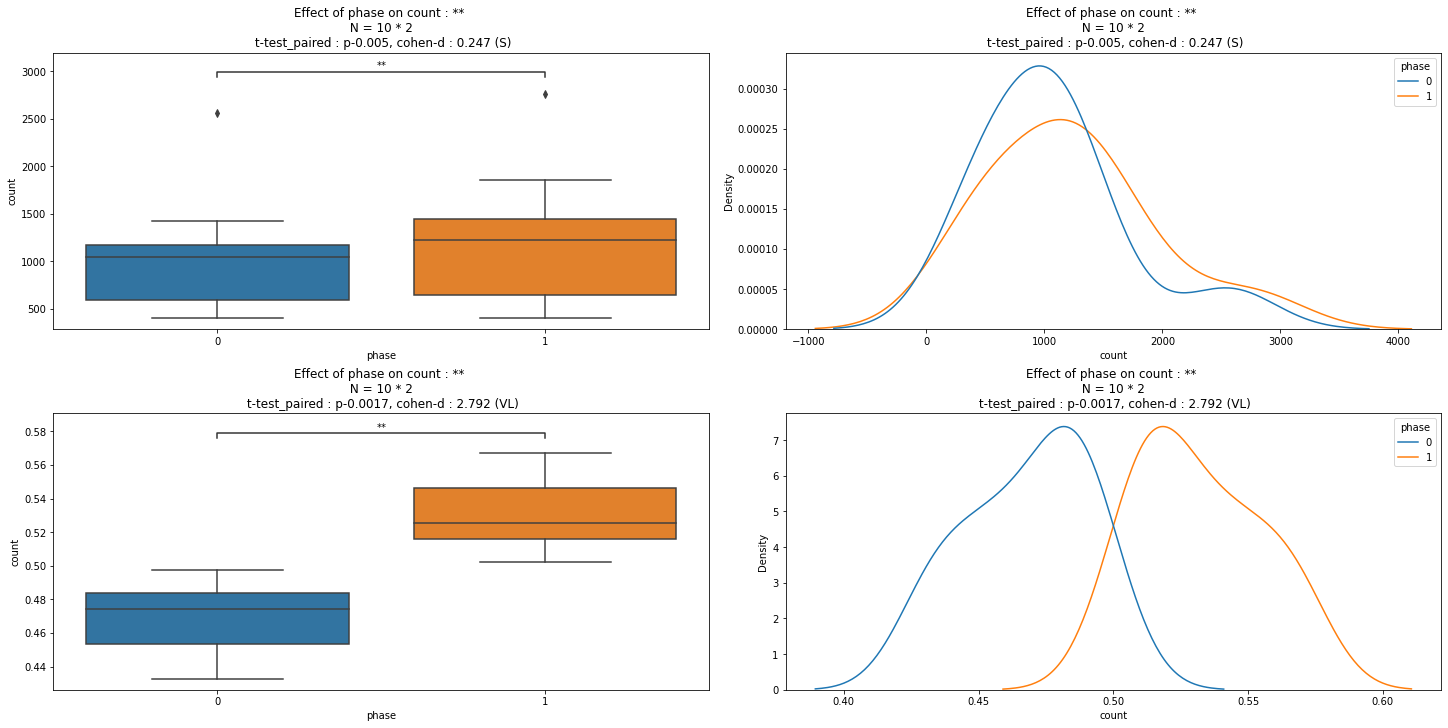

In [22]:
fig ,axs = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10), constrained_layout =True)

for row , norm in enumerate(['no', 'yes']):
    for col, mode in enumerate(['box','distribution']):
        ax = axs[row, col]
        gh.auto_stats(df=df_tidy[(df_tidy['stage'] == 'N2') & (df_tidy['norm'] == norm)] , predictor = 'phase', outcome = 'count' , design = 'within', ax=ax, mode = mode)

In [23]:
bin_1_prop = df_tidy[(df_tidy['stage'] == 'N2') & (df_tidy['norm'] == 'yes') & (df_tidy['phase'] == 1)]['count'].values
bin_0_prop = df_tidy[(df_tidy['stage'] == 'N2') & (df_tidy['norm'] == 'yes') & (df_tidy['phase'] == 0)]['count'].values

In [24]:
pg.ttest(x = bin_1_prop, y = 0.5)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.414395,9,two-sided,0.001685,"[0.52, 0.55]",1.395954,26.49,0.974309


In [25]:
pg.ttest(x = bin_0_prop, y = 0.5)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-4.414395,9,two-sided,0.001685,"[0.45, 0.48]",1.395954,26.49,0.974309


<AxesSubplot:xlabel='patient', ylabel='count'>

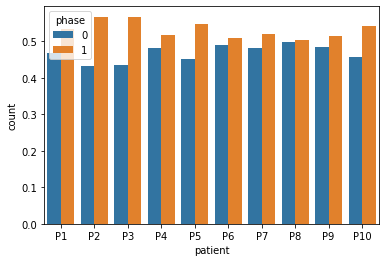

In [26]:
sns.barplot(data = df_tidy[(df_tidy['stage'] == 'N2') & (df_tidy['norm'] == 'yes')], x='patient', y ='count', hue = 'phase')

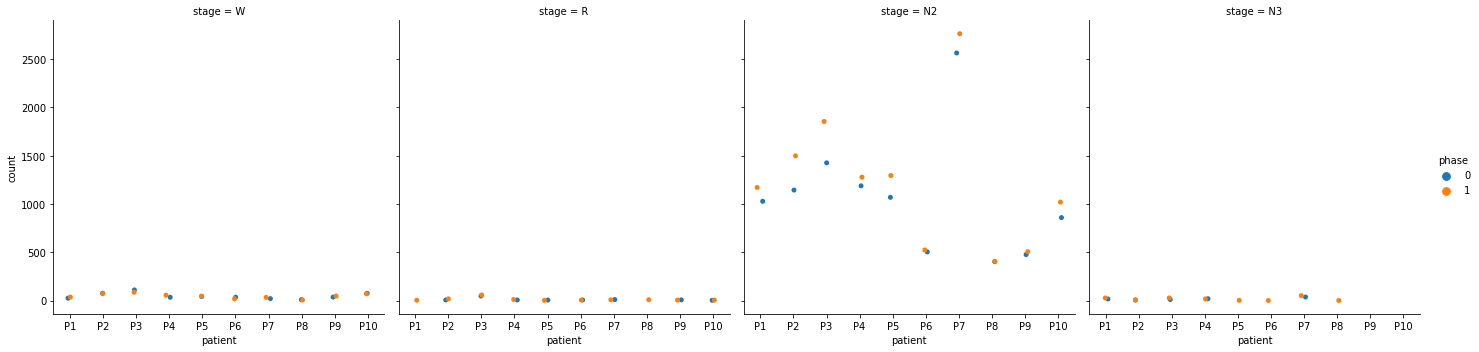

In [27]:
sns.catplot(data = df_tidy[df_tidy['norm'] == 'no'], x='patient', y ='count', hue = 'phase', col = 'stage')

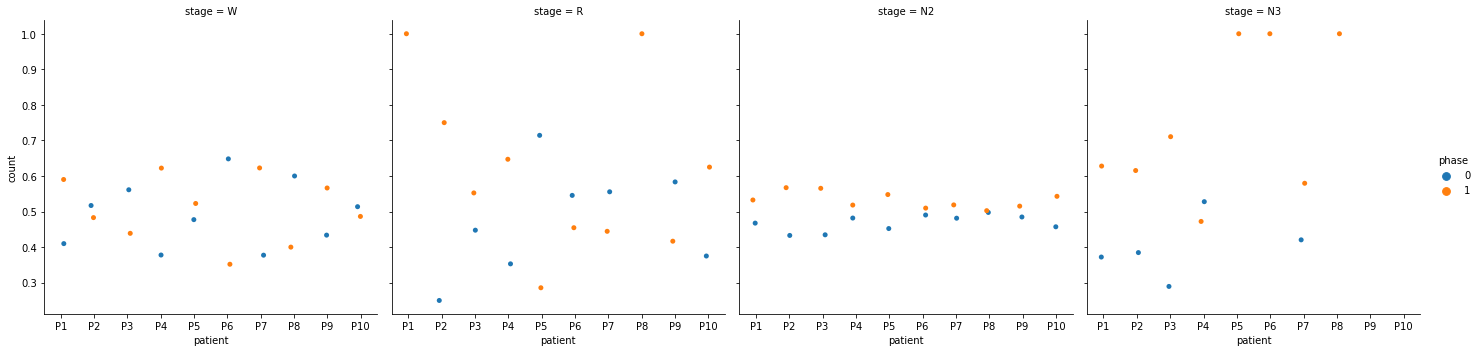

In [28]:
sns.catplot(data = df_tidy[df_tidy['norm'] == 'yes'], x='patient', y ='count', hue = 'phase', col = 'stage')

In [29]:
concat = []
for p in  patients:
    print(p)
    concat.append(all_in_one(p, nbins = 20))


P1
P2
P3
P4
P5
P6
P7
P8
P9
P10


In [30]:
df_20 = pd.concat(concat)

/tmp/ipykernel_1042371/3312757182.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_20.mean().plot.bar()


<AxesSubplot:>

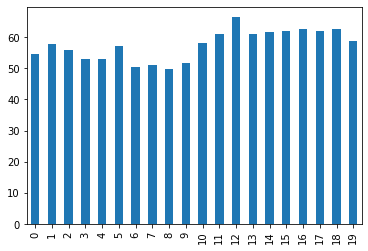

In [31]:
df_20.mean().plot.bar()

In [33]:
df_20

,patient,stage,norm,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,P1,N2,no,116.000000,98.000000,121.000000,95.000000,98.000000,106.000000,101.000000,...,110.000000,114.000000,117.000000,108.000000,114.000000,116.000000,153.000000,125.000000,112.000000,102.000000
0,P1,N2,yes,0.052751,0.044566,0.055025,0.043201,0.044566,0.048204,0.045930,...,0.050023,0.051842,0.053206,0.049113,0.051842,0.052751,0.069577,0.056844,0.050932,0.046385
0,P2,N2,no,116.000000,103.000000,104.000000,120.000000,119.000000,126.000000,117.000000,...,185.000000,181.000000,146.000000,153.000000,151.000000,144.000000,137.000000,139.000000,146.000000,117.000000
0,P2,N2,yes,0.043890,0.038971,0.039349,0.045403,0.045025,0.047673,0.044268,...,0.069996,0.068483,0.055240,0.057889,0.057132,0.054484,0.051835,0.052592,0.055240,0.044268
0,P3,N2,no,162.000000,145.000000,104.000000,112.000000,140.000000,130.000000,129.000000,...,158.000000,175.000000,207.000000,205.000000,209.000000,195.000000,159.000000,185.000000,204.000000,158.000000
0,P3,N2,yes,0.049375,0.044194,0.031698,0.034136,0.042670,0.039622,0.039317,...,0.048156,0.053337,0.063091,0.062481,0.063700,0.059433,0.048461,0.056385,0.062176,0.048156
0,P4,N2,no,118.000000,112.000000,130.000000,116.000000,128.000000,134.000000,105.000000,...,114.000000,139.000000,148.000000,132.000000,152.000000,120.000000,131.000000,116.000000,107.000000,119.000000
0,P4,N2,yes,0.047851,0.045418,0.052717,0.047040,0.051906,0.054339,0.042579,...,0.046229,0.056367,0.060016,0.053528,0.061638,0.048662,0.053122,0.047040,0.043390,0.048256
0,P5,N2,no,78.000000,121.000000,117.000000,111.000000,103.000000,114.000000,101.000000,...,111.000000,115.000000,144.000000,125.000000,137.000000,130.000000,156.000000,147.000000,113.000000,117.000000
0,P5,N2,yes,0.032995,0.051184,0.049492,0.046954,0.043570,0.048223,0.042724,...,0.046954,0.048646,0.060914,0.052876,0.057953,0.054992,0.065990,0.062183,0.047800,0.049492


In [32]:
def get_complex_vector(phase, amplitude, axis = 0):
    #### phase in radian
    #### amplitude 0/1 if spike or whaever positive values if continuous thing
    if np.sum(amplitude<0) >0:
        print('Caution ! Negative amplitude may disturb mesurement !')
    # vectors = np.zeros(phase.shape, dtype ='complex64')
    # vectors[:] = (amplitude*np.exp(1j*phase))
    vectors = amplitude.astype('float32') * np.exp((1j*phase).astype('complex64'))
    # print(vectors.dtype)
    mean_vector = np.nanmean(vectors, axis = axis)
    vectors = 0
    length = abs(mean_vector)
    angle = np.angle(mean_vector)
    if np.isscalar(angle):
        if angle<0:
            angle += 2*np.pi
    elif isinstance(angle, np.ndarray) :
        angle[angle<0] += np.ones(np.sum(angle<0))*2*np.pi
    else :
        print('unknown data type')
        exit()
    return angle, length


In [119]:
df_20_raw = df_20[df_20['norm'] == 'no']

In [120]:
df_20_raw.mean()

/tmp/ipykernel_1042371/2944027958.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_20_raw.mean()


0     108.9
1     115.4
2     111.6
3     105.6
4     105.7
5     113.9
6     100.6
7     101.7
8      99.6
9     103.1
10    116.2
11    121.7
12    132.8
13    122.1
14    123.4
15    124.0
16    125.0
17    124.1
18    125.4
19    117.1
dtype: float64

In [127]:
df_20_raw.iloc[4,3:].values

array([78.0, 121.0, 117.0, 111.0, 103.0, 114.0, 101.0, 85.0, 122.0, 117.0,
       111.0, 115.0, 144.0, 125.0, 137.0, 130.0, 156.0, 147.0, 113.0,
       117.0], dtype=object)

In [128]:
def phases_in_radian(nbins = 20):
    phases = np.linspace(0 , 2*np.pi , 20)
    return phases

In [130]:
phases = phases_in_radian(nbins = 20)

In [131]:
phases

array([0.])

In [135]:
np.linspace(0 , 2*np.pi , 20)

array([0.        , 0.33069396, 0.66138793, 0.99208189, 1.32277585,
       1.65346982, 1.98416378, 2.31485774, 2.64555171, 2.97624567,
       3.30693964, 3.6376336 , 3.96832756, 4.29902153, 4.62971549,
       4.96040945, 5.29110342, 5.62179738, 5.95249134, 6.28318531])

In [134]:
np.arange(20) / 20 * 2 * np.pi

array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
       1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
       3.14159265, 3.45575192, 3.76991118, 4.08407045, 4.39822972,
       4.71238898, 5.02654825, 5.34070751, 5.65486678, 5.96902604])

In [51]:
phases_in_radian().size

20

In [136]:
angle, length = get_complex_vector(phase=np.arange(20) / 20 * 2 * np.pi, amplitude=df_20_raw.mean().values)

/tmp/ipykernel_1042371/3326889762.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  angle, length = get_complex_vector(phase=np.arange(20) / 20 * 2 * np.pi, amplitude=df_20_raw.mean().values)


In [137]:
angle

4.792582098637716

In [138]:
length

5.7940845

In [118]:
np.ones(df_20_raw.mean().values)

/tmp/ipykernel_1042371/1770468085.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  np.ones(df_20_raw.mean().values)


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [55]:
angle

5.678204421197073

In [56]:
length

0.0035799257

/tmp/ipykernel_1042371/3509907808.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_20_raw.mean().round(3).plot.bar(ax=ax)


[Text(0, 0, '0.048'),
 Text(0, 0, '0.051'),
 Text(0, 0, '0.048'),
 Text(0, 0, '0.047'),
 Text(0, 0, '0.044'),
 Text(0, 0, '0.051'),
 Text(0, 0, '0.046'),
 Text(0, 0, '0.046'),
 Text(0, 0, '0.042'),
 Text(0, 0, '0.044'),
 Text(0, 0, '0.051'),
 Text(0, 0, '0.054'),
 Text(0, 0, '0.059'),
 Text(0, 0, '0.051'),
 Text(0, 0, '0.052'),
 Text(0, 0, '0.054'),
 Text(0, 0, '0.053'),
 Text(0, 0, '0.054'),
 Text(0, 0, '0.053'),
 Text(0, 0, '0.05')]

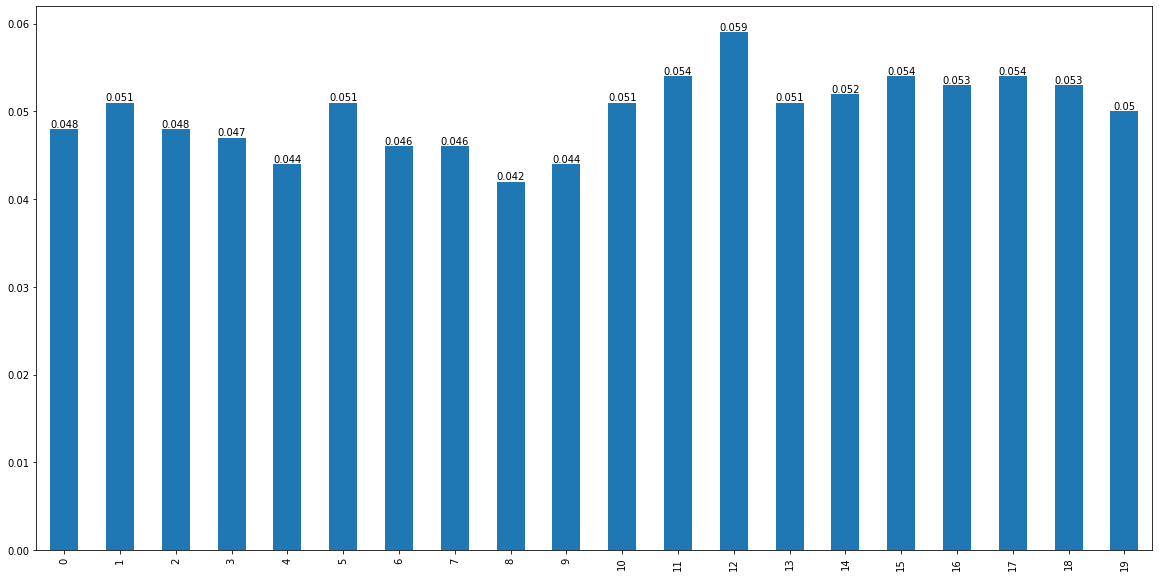

In [110]:
fig , ax = plt.subplots(figsize = (20,10))
df_20_raw.mean().round(3).plot.bar(ax=ax)
ax.bar_label(ax.containers[0])

In [111]:
concat = []
for patient in patients:
    concat.append(pd.read_excel(f'../df_analyse/resp_features_{patient}.xlsx', index_col = [0])
df_all_rsp_features = pd.concat(concat)

SyntaxError: invalid syntax (1903401853.py, line 4)

In [58]:
df_20

,patient,stage,norm,0,1,2,3,4,5,6,...,10,11,12,13,14,15,16,17,18,19
0,P1,N2,no,116.000000,98.000000,121.000000,95.000000,98.000000,106.000000,101.000000,...,110.000000,114.000000,117.000000,108.000000,114.000000,116.000000,153.000000,125.000000,112.000000,102.000000
0,P1,N2,yes,0.052751,0.044566,0.055025,0.043201,0.044566,0.048204,0.045930,...,0.050023,0.051842,0.053206,0.049113,0.051842,0.052751,0.069577,0.056844,0.050932,0.046385
0,P2,N2,no,116.000000,103.000000,104.000000,120.000000,119.000000,126.000000,117.000000,...,185.000000,181.000000,146.000000,153.000000,151.000000,144.000000,137.000000,139.000000,146.000000,117.000000
0,P2,N2,yes,0.043890,0.038971,0.039349,0.045403,0.045025,0.047673,0.044268,...,0.069996,0.068483,0.055240,0.057889,0.057132,0.054484,0.051835,0.052592,0.055240,0.044268
0,P3,N2,no,162.000000,145.000000,104.000000,112.000000,140.000000,130.000000,129.000000,...,158.000000,175.000000,207.000000,205.000000,209.000000,195.000000,159.000000,185.000000,204.000000,158.000000
0,P3,N2,yes,0.049375,0.044194,0.031698,0.034136,0.042670,0.039622,0.039317,...,0.048156,0.053337,0.063091,0.062481,0.063700,0.059433,0.048461,0.056385,0.062176,0.048156
0,P4,N2,no,118.000000,112.000000,130.000000,116.000000,128.000000,134.000000,105.000000,...,114.000000,139.000000,148.000000,132.000000,152.000000,120.000000,131.000000,116.000000,107.000000,119.000000
0,P4,N2,yes,0.047851,0.045418,0.052717,0.047040,0.051906,0.054339,0.042579,...,0.046229,0.056367,0.060016,0.053528,0.061638,0.048662,0.053122,0.047040,0.043390,0.048256
0,P5,N2,no,78.000000,121.000000,117.000000,111.000000,103.000000,114.000000,101.000000,...,111.000000,115.000000,144.000000,125.000000,137.000000,130.000000,156.000000,147.000000,113.000000,117.000000
0,P5,N2,yes,0.032995,0.051184,0.049492,0.046954,0.043570,0.048223,0.042724,...,0.046954,0.048646,0.060914,0.052876,0.057953,0.054992,0.065990,0.062183,0.047800,0.049492


In [59]:
df_to_study = df_20.set_index(['patient','stage','norm'])
rows = []
for patient in patients:
    for norm in ['no','yes']:
        angle, length = get_complex_vector(phase=phases_in_radian(), amplitude=df_to_study.loc[(patient, 'N2', norm) , :])
        row = [patient , norm , angle, length]
        rows.append(row)
df_mi = pd.DataFrame(rows, columns = ['patient' , 'norm' , 'angle' , 'length'])
    

In [60]:
df_mi

,patient,norm,angle,length
0,P1,no,5.658145,9.797327
1,P1,yes,5.658145,0.004455
2,P2,no,4.728863,10.255398
3,P2,yes,4.728863,0.003880
4,P3,no,4.916801,17.267103
5,P3,yes,4.916801,0.005263
6,P4,no,5.623581,5.692597
7,P4,yes,5.623581,0.002308
8,P5,no,5.375940,10.387248
9,P5,yes,5.375940,0.004394


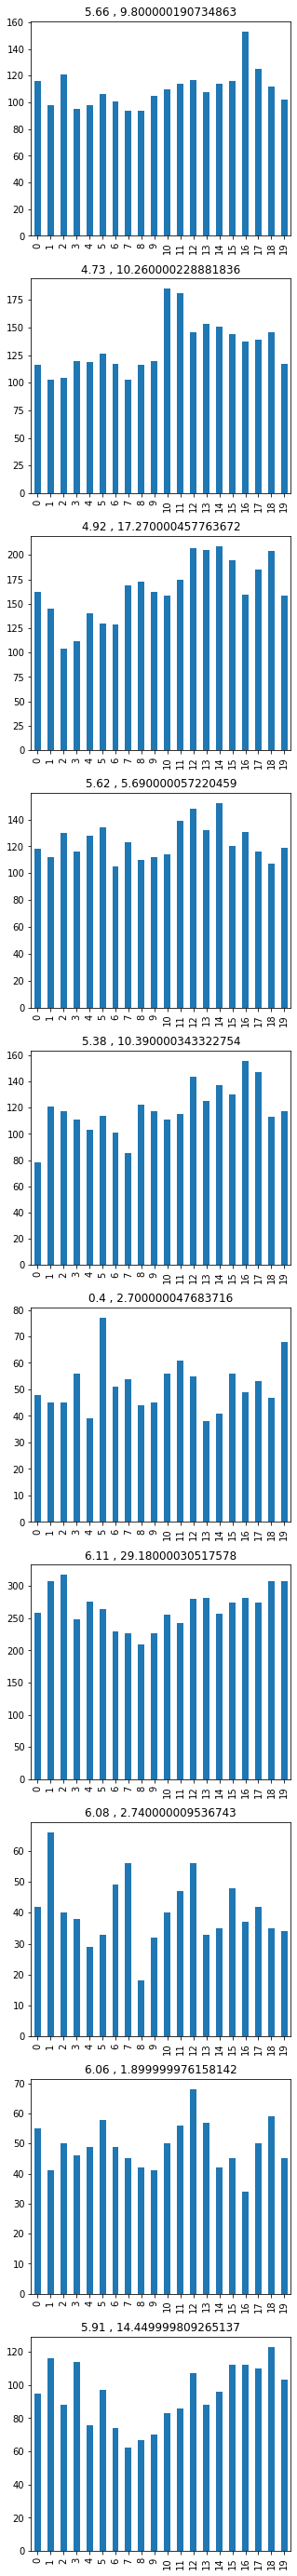

In [96]:
fig ,axs = plt.subplots(nrows = 10, figsize = (5,50))
for row, patient in enumerate(patients):
    ax = axs[row]
    df_20[df_20['norm'] == 'no'].set_index(['patient','stage','norm']).loc[(patient,'N2','no'), :].plot.bar(ax=ax)
    angle = df_mi.set_index(['patient','norm']).loc[(patient,'no'),'angle'].round(2)
    length = df_mi.set_index(['patient','norm']).loc[(patient,'no'),'length'].round(2)
    title = f'{angle} , {length}'
    ax.set_title(title)

In [ ]:
circular_hist(ax[0], angles0)